In [1]:
#importar paquetes
%matplotlib inline
from MIfunctions import * #importar todas las funciones de manejo de eeg con mne
####################################################
#clase principal reduccion de dimension con kernels
from MiniBatchCKA import MiniBatchCKA # Aqui importar la funcion de reduccion con itl
###################################################

import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, lfilter, welch, lfilter_zi #, freqz
import numpy as np
from mne.io import read_raw_edf
from mne.decoding import CSP
import pandas as pd
import json as  js #conda install -c jmcmurray json
import warnings
import seaborn as sns
import mne

from numpy import matlib
import os
from matplotlib.animation import FuncAnimation
from ipywidgets import interact

import cv2 

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from joblib import dump, load
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
from mne import Epochs, pick_types, events_from_annotations

In [2]:
#cargar datos
sbj = 8 #sujeto sbj+1
name = 'data/A0' + str(sbj)
filename_train = name+'T.gdf'
Ch = np.arange(0,22)# lectura canales eeg
clases = [769,770] # clases izquierda y derecha
vt = [-1,3] #escoger ventana de analisis : -li:lf desde el estimulo cue
i_muestras, i_clases, raw, Xraw, y, ni,m = leer_bci42a_train_full(filename_train,clases,Ch,vt)
fs = raw.info['sfreq'] #frecuencia de muestreo
print(fs)

Extracting EDF parameters from E:\My Drive\UNAL\Clases\2020-1\TeoInformacion\TeoriaInformacion\CodesBCIITL\data\A08T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
250.0


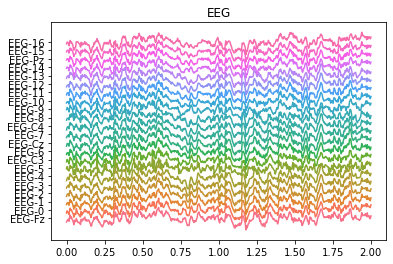

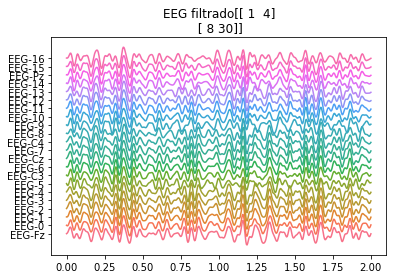

In [3]:
#%% primer filtrado 8-30 [Hz]
f_frec = np.array([[1,4],[8,30]])
Xrawf = np.squeeze(bank_filter_epochsEEG(Xraw, fs, f_frec))
plt.figure(1)
plt.title('EEG')
plot_eeg(data=Xraw[0],sample_rate=fs,channels_names=[raw.ch_names[i] for i in Ch])
plt.figure(2)
plt.title('EEG filtrado'+str(f_frec))
plot_eeg(data=Xrawf[0,:,:,1],sample_rate=fs,channels_names=[raw.ch_names[i] for i in Ch])

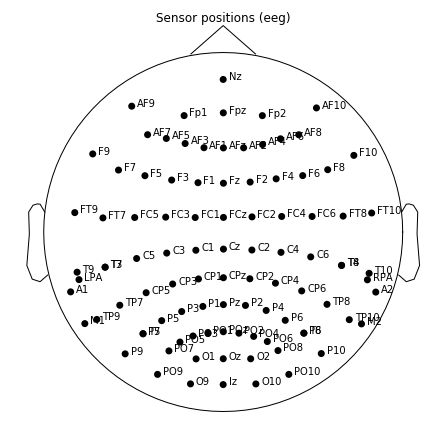

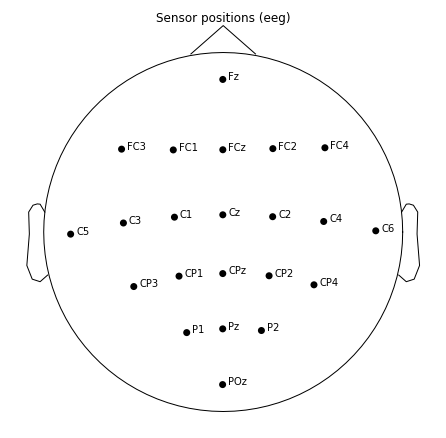

In [4]:
#fijar montaje para graficar
#se deben ajustar los nombres de los canales al montaje 10-20 de mne
montage = mne.channels.read_montage('standard_1020') #"standard_1020"
#montage = mne.channels.make_standard_montage(kind='biosemi64')
info = mne.create_info(montage.ch_names, sfreq=250, ch_types="eeg",
                           montage=montage)
mne.viz.plot_sensors(info, show_names=True)
plt.show()
#canales base de datos
channels_names = ['Fz','FC3','FC1','FCz','FC2','FC4',
                 'C5','C3','C1','Cz','C2','C4','C6',
                 'CP3','CP1','CPz','CP2','CP4',
                  'P1','Pz','P2',
                   'POz']
# Se crea un objeto mne con el montaje de los electrodos usados
montage = mne.channels.read_montage('standard_1020', channels_names)
info = mne.create_info(channels_names, sfreq=250, ch_types="eeg",
                           montage=montage)
mne.viz.plot_sensors(info, show_names=True)
plt.show()

In [5]:
#prueba csp
f_frec = np.array([[1,4],[4,8],[8,12],[12,30],[8,30]]) #estudiar representacion por bandas de ritmos cerebrales
#ver explicación de bandas:
#https://en.wikipedia.org/wiki/Neural_oscillation
ncomp = Xraw.shape[1]
csp = CSP_epochs_filter_extractor(fs=fs,f_frec=f_frec,ncomp = ncomp,reg='empirical') #reg = 'shrunk'
#ver funcionamiento caracterizacion de common spatial patterns -> especial para motor imagery
#https://en.wikipedia.org/wiki/Common_spatial_pattern
#https://es.slideshare.net/yokotatsuya/introduction-to-common-spatial-pattern-filters-for-eeg-motor-imagery-classification
Xcsp = csp.fit_transform(Xraw,y)
Xcsp.shape #el numero de atributos P = numerodebandas X ncomp de csp
#N = 132 muestras, P = 110 caracteristicas desde csp por bandas

(132, 110)

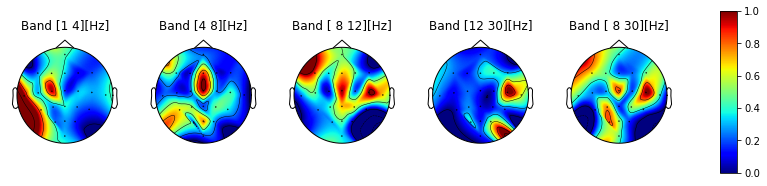

In [6]:
#visualizar en topoplot (grafica sobre sensores), canales con mas peso por representacion por bandas desde csp
f, ax = plt.subplots(1,len(csp.csp_l),figsize=(12,3))
rhov = np.zeros((csp.csp_l[0].patterns_.shape[0],len(csp.csp_l)))
cmap = 'jet'
for i in range(len(csp.csp_l)):
    rhov[:,i] = np.mean(abs(csp.csp_l[i].patterns_),axis=1) #promediar pesos sobre representacion de csp
    rhov[:,i] = rhov[:,i]/max(rhov[:,i])
    mne.viz.plot_topomap(rhov[:,i], info, axes=ax[i], show=False,cmap=cmap)
    ax[i].set_title('Band '+str(f_frec[i])+'[Hz]')
 
cax = f.add_axes([0.95, 0.15, 0.02, 0.75])
norm = matplotlib.colors.Normalize(vmin=0,vmax=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm,cax=cax)
plt.show()


In [7]:
#estudiar eficacia de representación - proyeccion 2D 
scaler = StandardScaler()
#estandarizar datos antes de aplicar cualquier tecnica de gradiente descendiente
Xcspz = scaler.fit_transform(Xcsp)
#aplicar algoritmo de proyeccion basado en kernels
epochs = 200
batch = 30
eta = 5e-1
epocket = 30
init = 'random' #init='pca'
cka = MiniBatchCKA(showCommandLine=True,epoch=epochs,max_errpocket=epocket,batch=batch,learning_rate=eta,init=init)
z = cka.fit_transform(Xcspz,y)


epoch:1/200--- fcostbest: 1.0244023e+00 --- fcost:1.0244023e+00 --- errpoket:0/30 --- elapsed:0.02 [s]

epoch:1/200--- fcostbest: 1.0244023e+00 --- fcost:1.0244023e+00 --- errpoket:0/30 --- elapsed:0.03 [s]

epoch:1/200--- fcostbest: 1.0244023e+00 --- fcost:1.0244023e+00 --- errpoket:0/30 --- elapsed:0.03 [s]

epoch:1/200--- fcostbest: 1.0244023e+00 --- fcost:1.0244023e+00 --- errpoket:1/30 --- elapsed:0.04 [s]

epoch:2/200--- fcostbest: 1.0244023e+00 --- fcost:1.0244023e+00 --- errpoket:2/30 --- elapsed:0.04 [s]

epoch:2/200--- fcostbest: 1.0244023e+00 --- fcost:1.0244023e+00 --- errpoket:3/30 --- elapsed:0.05 [s]

epoch:2/200--- fcostbest: 1.0244023e+00 --- fcost:1.0244023e+00 --- errpoket:4/30 --- elapsed:0.05 [s]

epoch:2/200--- fcostbest: 1.0244023e+00 --- fcost:1.0244023e+00 --- errpoket:5/30 --- elapsed:0.06 [s]

epoch:3/200--- fcostbest: 1.0244023e+00 --- fcost:1.0244023e+00 --- errpoket:6/30 --- elapsed:0.06 [s]

epoch:3/200--- fcostbest: 1.0244023e+00 --- fcost:1.0244023e+00 


epoch:23/200--- fcostbest: 1.0244052e+00 --- fcost:1.0244023e+00 --- errpoket:2/30 --- elapsed:0.40 [s]

epoch:24/200--- fcostbest: 1.0244052e+00 --- fcost:1.0244023e+00 --- errpoket:3/30 --- elapsed:0.41 [s]

epoch:24/200--- fcostbest: 1.0244052e+00 --- fcost:1.0244023e+00 --- errpoket:4/30 --- elapsed:0.41 [s]

epoch:24/200--- fcostbest: 1.0244052e+00 --- fcost:1.0244024e+00 --- errpoket:5/30 --- elapsed:0.42 [s]

epoch:24/200--- fcostbest: 1.0244052e+00 --- fcost:1.0244023e+00 --- errpoket:6/30 --- elapsed:0.42 [s]

epoch:25/200--- fcostbest: 1.0244052e+00 --- fcost:1.0244023e+00 --- errpoket:7/30 --- elapsed:0.42 [s]

epoch:25/200--- fcostbest: 1.0244052e+00 --- fcost:1.0244027e+00 --- errpoket:8/30 --- elapsed:0.43 [s]

epoch:25/200--- fcostbest: 1.0244052e+00 --- fcost:1.0244024e+00 --- errpoket:9/30 --- elapsed:0.43 [s]

epoch:25/200--- fcostbest: 1.0244052e+00 --- fcost:1.0244024e+00 --- errpoket:10/30 --- elapsed:0.44 [s]

epoch:26/200--- fcostbest: 1.0244052e+00 --- fcost:1.

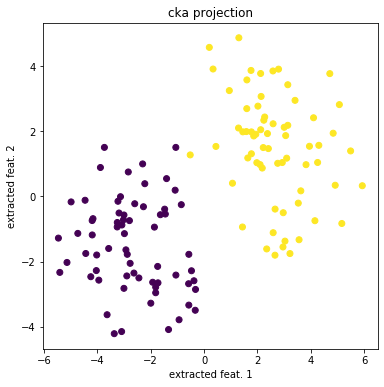

In [8]:
#pintar proyeccion 2D
plt.figure(figsize=(6,6))
plt.scatter(z[:,0],z[:,1],c=y)
plt.title('cka projection')
plt.xlabel('extracted feat. 1')
plt.ylabel('extracted feat. 2')
plt.show()


In [9]:
#prueba en pipeline de clasificacion
steps = [('rep', CSP_epochs_filter_extractor(fs=fs,f_frec=f_frec,reg='empirical')), #representacion por csp en bandas
         ('scaler', StandardScaler()), #estandarizar
         ('proy', MiniBatchCKA(epoch=epochs,max_errpocket=epocket,batch=batch,learning_rate=eta)), #proyeccion 
         #('cla',  KNeighborsClassifier())] #clasificador 
          ('cla',  GaussianNB())] #clasificador 
method = Pipeline(steps)          

#parametros a buscar por busqueda por grilla
parameters ={'rep__ncomp':[4,8,16,Xraw.shape[1]]}

In [10]:
#valildacion cruzada anidada
Niter = 10 #numero particiones
acc =np.zeros(Niter)#arreglo para guardar acierto
Nc = len(np.unique(y))
cmc = np.zeros((Niter,Nc,Nc))#arreglo para guarda matrices de confusion
best_estimators = []#mejor metodo por iteracion
for j in range(Niter):
        print('it %d/%d'%(j+1,Niter))
        X_train, X_test, y_train, y_test = train_test_split(Xraw,y,test_size=0.2, stratify=y)
        grid_search = GridSearchCV(method, parameters,cv=5,verbose=10,scoring='accuracy',n_jobs=4)
        #generar mejor modelo
        grid_search.fit(X_train,y_train)
        #estimar salida conjunto de test
        y_pred = grid_search.best_estimator_.predict(X_test)
        #guardar mejor modelo
        best_estimators.append(grid_search.best_estimator_)
        
        #guardar acierto
        acc[j] = 100*accuracy_score(y_test,y_pred)
        #estimar matriz de confusion
        cm = confusion_matrix(y_test, y_pred)
        cm = 100*cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cmc[j] = cm
        print('it %d/%d'%(j+1,Niter))
        print(grid_search.best_params_)
        print('acc:',acc[j])
        print('confusionmatrix \n',cmc[j])
        savedata = {
            'acc':acc,
            'confusionmatrix':cmc,
            'best_models':best_estimators
              } 
        dump(savedata,'results/BCI2a.joblib')


it 1/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    9.7s
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:   12.5s remaining:    3.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   15.1s finished


it 1/10
{'rep__ncomp': 4}
acc: 88.88888888888889
confusionmatrix 
 [[84.61538462 15.38461538]
 [ 7.14285714 92.85714286]]
it 2/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:    9.8s remaining:    2.4s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   11.8s finished


it 2/10
{'rep__ncomp': 8}
acc: 92.5925925925926
confusionmatrix 
 [[100.           0.        ]
 [ 15.38461538  84.61538462]]
it 3/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:    9.3s remaining:    2.2s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   11.6s finished


it 3/10
{'rep__ncomp': 4}
acc: 81.48148148148148
confusionmatrix 
 [[84.61538462 15.38461538]
 [21.42857143 78.57142857]]
it 4/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:    9.2s remaining:    2.2s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   11.6s finished


it 4/10
{'rep__ncomp': 8}
acc: 92.5925925925926
confusionmatrix 
 [[92.30769231  7.69230769]
 [ 7.14285714 92.85714286]]
it 5/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:   10.3s remaining:    2.5s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   12.7s finished


it 5/10
{'rep__ncomp': 8}
acc: 81.48148148148148
confusionmatrix 
 [[76.92307692 23.07692308]
 [14.28571429 85.71428571]]
it 6/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:    9.5s remaining:    2.3s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   11.9s finished


it 6/10
{'rep__ncomp': 8}
acc: 88.88888888888889
confusionmatrix 
 [[85.71428571 14.28571429]
 [ 7.69230769 92.30769231]]
it 7/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:    9.4s remaining:    2.3s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   12.2s finished


it 7/10
{'rep__ncomp': 4}
acc: 100.0
confusionmatrix 
 [[100.   0.]
 [  0. 100.]]
it 8/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:    9.3s remaining:    2.2s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   11.6s finished


it 8/10
{'rep__ncomp': 4}
acc: 88.88888888888889
confusionmatrix 
 [[ 78.57142857  21.42857143]
 [  0.         100.        ]]
it 9/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:    9.6s remaining:    2.3s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   12.2s finished


it 9/10
{'rep__ncomp': 8}
acc: 96.29629629629629
confusionmatrix 
 [[ 92.85714286   7.14285714]
 [  0.         100.        ]]
it 10/10
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    6.8s
[Parallel(n_jobs=4)]: Done  16 out of  20 | elapsed:    9.7s remaining:    2.3s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   12.0s finished


it 10/10
{'rep__ncomp': 8}
acc: 88.88888888888889
confusionmatrix 
 [[84.61538462 15.38461538]
 [ 7.14285714 92.85714286]]


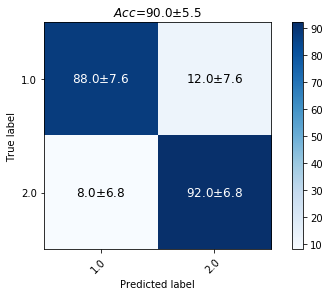

In [11]:
#cargar resultados y graficar promedios por iteraciones
loadeddata = load('results/BCI2a.joblib')
acc = loadeddata['acc']
cmc = loadeddata['confusionmatrix']
best_estimators = loadeddata['best_models']

plot_confusion_matrix_MS(np.mean(cmc,axis=0), np.std(cmc,axis=0), np.unique(y))
plt.title('${Acc}$='+ format(np.mean(acc),'.1f') +'$\pm$'+ format(np.std(acc),'.1f'))
plt.show()
